In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\Users\\asus\\anaconda3\\lib\\site-packages\\pyspark'

In [3]:
from pyspark import SparkContext 
sc = SparkContext(master="local[1]")
sc

<SparkContext master=local[1] appName=pyspark-shell>

In [4]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)

In [5]:
# Загружаем файл (файл заранее немного был изменен в Pandas, a именно удалены \n, "" и другие знаки)
df = sqlContext.read \
               .option("header",True) \
               .option("multiline", True) \
               .csv("new_toxic_comments2.csv") 

In [6]:
df.show(3)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|Explanation Why t...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man  I'm real...|    0|           0|      0|     0|     0|            0|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 3 rows



In [7]:
label_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [8]:
# Число признаков. К сожалению не удалось взять большое число признаков, так например 
# уже для 400 признаков вылезала ошибка memory_out
NUMFEATURES_1 = 50
NUMFEATURES_2 = 100
NUMFEATURES_3 = 200
NUMFEATURES_4 = 300

In [9]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import *

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [10]:
def get_features(df_train, df_test, num_featrues, min_count=3, w2v = False):
    """Возвращает трейновый и тестовый датасет с признаками"""
    
    regexTokenizer = RegexTokenizer(inputCol="comment_text", outputCol="words", pattern="\\W")
    eng_stopwords = StopWordsRemover.loadDefaultStopWords("english")
    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(eng_stopwords)
    # hashingTF, IDF
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=num_featrues)
    idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=min_count)
    
    # word_to_vec
    w2v = Word2Vec(vectorSize=num_featrues, minCount=min_count, inputCol="filtered", outputCol="features")
    
    if w2v:
        pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, w2v])
    else:
        pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf])
    
    pipelineFit = pipeline.fit(df_train)
    
    train_dataset = pipelineFit.transform(df_train)
    test_dataset = pipelineFit.transform(df_test)
    train_dataset = train_dataset.select(["features"] + label_columns)
    test_dataset = test_dataset.select(["features"] + label_columns)
    return train_dataset, test_dataset

In [11]:
class LabelModel:
      
    def __init__(self, 
                 label, 
                 train_dataset,
                 test_dataset, 
                 max_iter=20, 
                 regParam=0.01, 
                 elasticNetParam=0):
        
        self.label = label
        self.train_dataset = train_dataset.select(col('features').alias('features'), 
                                                  col(label).alias("label"))
        
        self.test_dataset = test_dataset.select(col('features').alias('features'), 
                                                col(label).alias("label"))
        
        self.model = LogisticRegression(maxIter=max_iter, 
                                        regParam=regParam, 
                                        elasticNetParam=elasticNetParam)
        
        
        self.evaluator = BinaryClassificationEvaluator(labelCol="label", 
                                                       rawPredictionCol="prediction", 
                                                       metricName='areaUnderROC')
        self.predictions = None
          
    def change_label_type(self, df):
        return df.withColumn("label", df["label"].cast(IntegerType()))
    
    
    def fit_model(self):
        self.train_dataset = self.change_label_type(self.train_dataset)
        self.model = self.model.fit(self.train_dataset)
           
    def evaluate_model(self):
        self.test_dataset = self.change_label_type(self.test_dataset)
        self.predictions = self.model.transform(self.test_dataset)
        return self.evaluator.evaluate(self.predictions)

In [13]:
def get_results(num_features=NUMFEATURES_1, w2v = False):
    """Возвращает dict: {label: score_for_label_model}"""
    train_dataset, test_dataset = get_features(df_train=df_train,
                                               df_test = df_test,
                                               num_featrues=num_features, 
                                               w2v = w2v)  
    models_dict = {label: LabelModel(label, train_dataset, test_dataset) for label in label_columns}
    result = {}
    for label, model in models_dict.items():
        model.fit_model()
        result[label] = model.evaluate_model()
    return result

In [14]:
# Делим данные на трейн и тест
df_train, df_test = df.randomSplit([0.7, 0.3])

### HashingTF, IDF

In [ ]:
tfidf_result_1 = get_results(NUMFEATURES_1)
tfidf_result_2 = get_results(NUMFEATURES_2)
tfidf_result_3 = get_results(NUMFEATURES_3)
tfidf_result_4 = get_results(NUMFEATURES_4)

In [28]:
def plot_metrics(data, labels=["50", "100", "200", "300"]):
    X = np.arange(6)
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, data[0].values(), color = 'b', width = 0.25)
    ax.bar(X + 0.20, data[1].values(), color = 'c', width = 0.25)
    ax.bar(X + 0.40, data[2].values(), color = 'g', width = 0.25)
    ax.bar(X + 0.60, data[3].values(), color = 'r', width = 0.25)
    ax.set_ylabel('roc_AUC', fontsize=14)
    ax.set_xlabel('Labels', fontsize=14)
    plt.title("Metrics", fontsize=18)
    ax.legend(labels=labels)
    ax.grid()

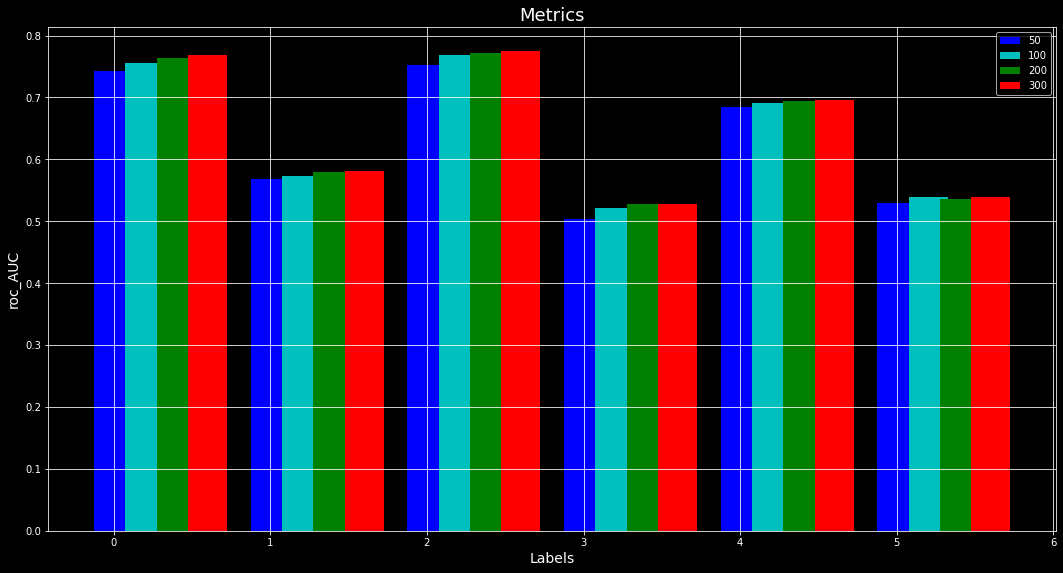

In [29]:
all_results_lst = [tfidf_result_1, tfidf_result_2, tfidf_result_3, tfidf_result_4]
plot_metrics(all_results_lst)

Как видно с ростом числа признаков в среднем результат растет, хотя и немного.

### Word2Vec

In [ ]:
w2v_result_1 = get_results(NUMFEATURES_1, w2v=True)
w2v_result_2 = get_results(NUMFEATURES_2, w2v=True)
w2v_result_3 = get_results(NUMFEATURES_3, w2v=True)
w2v_result_4 = get_results(NUMFEATURES_4, w2v=True)

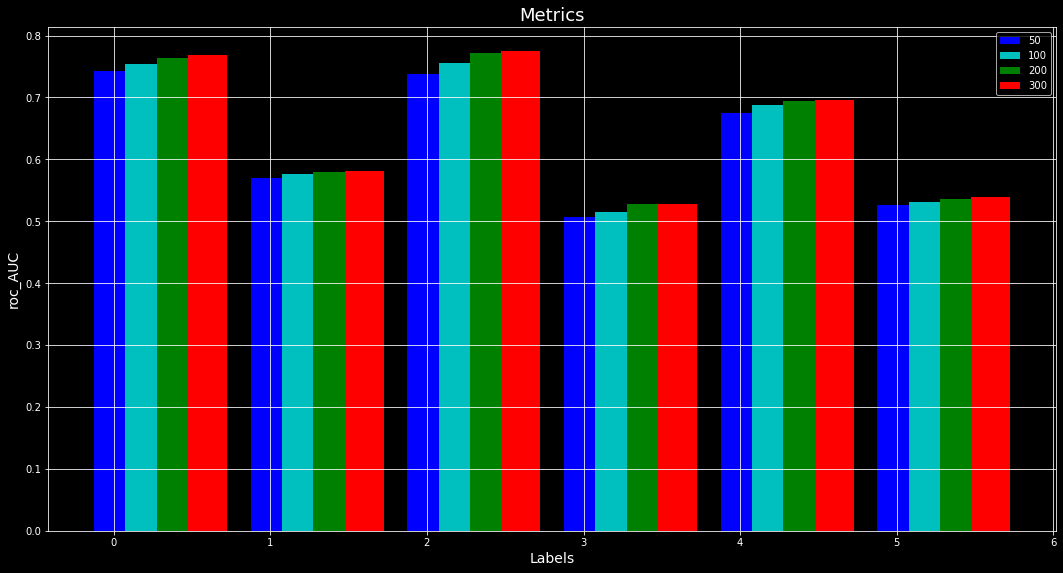

In [30]:
all_results_lst_w2v = [w2v_result_1, w2v_result_2, w2v_result_3, w2v_result_4]
plot_metrics(all_results_lst_w2v)

Видно, что в среднем результаты практически не отличаются от предыддущего подхода. Может быть это связано с тем, что число признаков не очень большое 

In [34]:
sc.stop()